<a href="xxx" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS Reading Session - 18-Feb-22. 

Prepared by: Narmina Yadullayeva

## Introduction

This notebook essentially has two parts:

* [Part 1. Vision Transformer: introduction](#first-bullet)

* [Part 2. Transformers in Action: Hugging Face.](#second-bullet)

The goal of this notebook is to give an overview of transformer architecture, its application to computer vision problems, and also show some examples of transformers in action.

## Part 1. Vision Transformer: introduction. <a class="anchor" id="first-bullet"></a>

Vision Transformers were first introduced in the paper AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE by the Google Brain team in late October 2020 (https://arxiv.org/abs/2010.11929).

To understand how ViT works, obviously you must have prior knowledge about how Transformers work and what problems it solved. I'll briefly introduce you to how transformers work before getting into the details of the topic at hand - ViT.

If you are new to NLP and interested in learning more about the transformer models and get a fair intuition of how they actually work, I recomment checking out the fantastic blog posts of [Jay Allamar](https://jalammar.github.io/).

### Transformers: A brief overview

> **If you already understand Transformers, feel free to skip ahead to the next section.**

Transformer models well and truly revolutionized Natural Language Processing as we know. When they were first introduced they broke multiple NLP records and were pushing the then State of the Art. Now, they have become a de-facto standard for modern NLP tasks and they bring spectacular performance gains when compared to the previous generation of models like LSTMs and GRUs.  

By far the most important paper that transformed the NLP landscape is the ["Attention is all you need"](https://arxiv.org/pdf/1706.03762.pdf) paper. The transformer architecture was introduced in this paper. 

### Motivations:

The existing models at that time for sequence and NLP tasks mostly involved RNNs. **The problem with these networks were that they couldn't capture long term dependencies.** 

LSTMs and GRUs - variants of RNNs were capable of capturing the dependencies but it is also limited. 

So, the main inspiration behind the transformer was to get rid of this recurrence and still end up capturing almost all the dependencies, to be precise global dependencies, yes the reference window of tranformers is full-range. This was achieved using a variant of attention mechanism called *self-attention* (multi-headed) which is very important for their success. One other advantage of Tranformer models are that they are highly parallelizable.  


### Transformer Architecture
**Note: The architecture diagrams are annotated with the corresponding step in the explanation.**

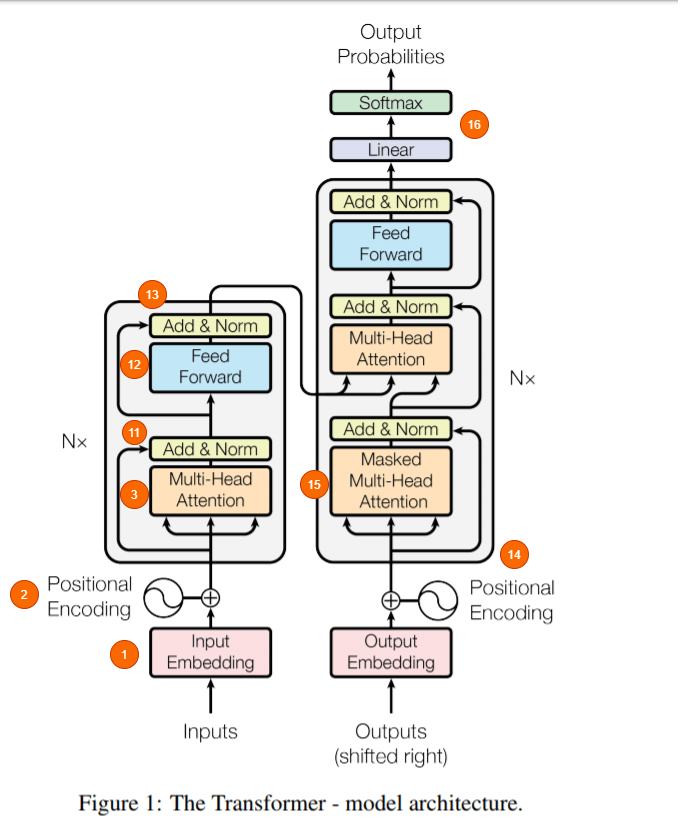

- Transformer has two parts, the encoder which is on the left side on the above diagram and the decoder which is on the right. 
- Imagine we are doing machine translation for now.
- The encoder takes the input data (sentence), and produces an intermediate representation of the input. 
- The decoder decodes this intermediate representation step by step and generates the output. The difference however is in how it is doing this. 
- Understanding the Encoder section is enough for ViT. 

> **Note: The explanations here are more about the intuition behind the architectures. For more mathematical details check out the respective research papers instead.**

### Tranformers: Step by step overview
**(1)** The input data first gets embedded into a vector. The embedding layer helps us grab a learned vector representation for each word.

**(2)** In the next stage a positional encoding is injected into the input embeddings. This is because a transformer has no idea about the order of the sequence that is being passed as input - for example a sentence.

**(3)** Now the multi-headed attention is where things get a little different. 

**Multi-headed-attention architecture:**
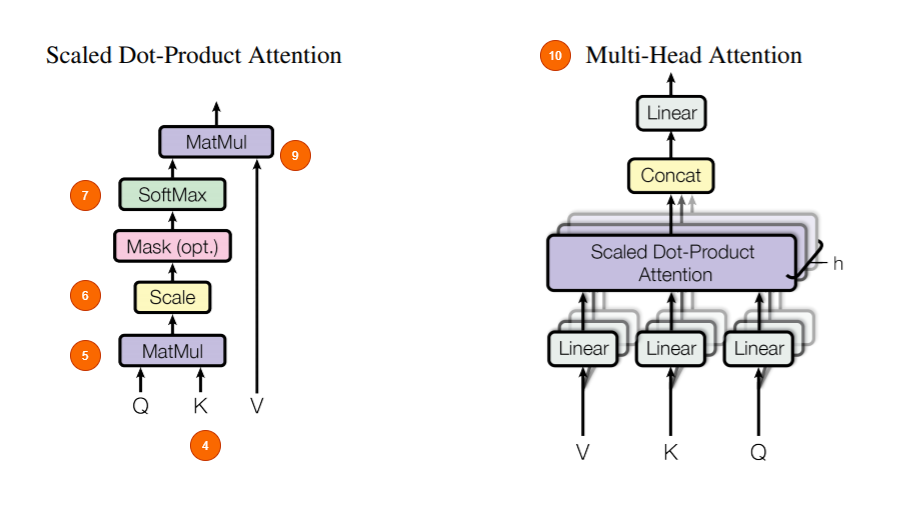

**(4)** Multi-Headed Attention consists of three learnable vectors. Query, Key and Value vectors. The motivation of this reportedly comes from information retrival where you search (query) and the search engine compares your query with a key and responds with a value. 

**(5)** The Q and K representations undergo a dot product matrix multiplication to produce a score matrix which represents how much a word has to attend to every other word. Higher score means more attention and vice-versa. 

**(6)** Then the Score matrix is scaled down according to the dimensions of the Q and K vectors. This is to ensure more stable gradients as multiplication can have exploding effects. 

(We'll discuss the mask part when we reach the decoder section)

**(7)** Next the Score matrix is softmaxed to turn attention scores into probabilities. Obviously higher scores are heightened and lower scores are depressed. This ensures the model to be confident on which words to attend to. 

**(8)** Then the resultant matrix with probabilites is multiplied with the value vector. This will make the higher probaility scores the model has learned to be more important. The low scoring words will effectively drown out to become irrelevant. 

**(9)** Then, the concatenated output of QK and V vectors are fed into the Linear layer to process further. 

**(10)** Self-Attention is performed for each word in the sequence. Since one doesn't depend on the other a copy of the self attention module can be used to process everything simultaneously making this **multi-headed**. 

**(11)** Then the output value vectors are concatenated and added to the residual connection coming from the input layer and then the resultant respresentation is passed into a *LayerNorm* for normalization. (Residual connection help gradients flow through the network and LayernNorm helps reduce the training time by a small fraction and stabilize the network)

**(12)** Further, the output is passed into a point-wise feed forward network to obtain an even richer representation.  

**(13)** The outputs are again Layer-normed and residuals are added from the previous layer. 


**Note: This wraps up the encoder section and trust me this is enough to fully understand Vision Transformer. I'll be largely leaving it up to you to understand the decoder part as it is very similar to the encoding layer.**

**(14)** The output from the encoder along with the inputs (if any) from the previous time steps/words are fed into the decoder where the outputs undergo masked-multi headed attention before being fed into the next attention layer along with the output from encoder. 

**(15)** Masked multi headed attention is necessary because the network shouldn't have any visibility into the words that are to come later in the sequence while decoding, to ensure there is no leak. This is done by masking the entries of words that come later in the series in the Score matrix. Current and previous words in the sequence are added with 1 and the future word scores are added with `-inf`. This ensures the future words in the series get drowned out into 0 when performing softmax to obtain the probabilities, while the rest are retained. 

**(16)** There are residual connections here as well, to improve the flow of gradients. Finally the output is sent to a Linear layer and softmaxed to obtain the outputs in probabilities. 

## How Vision Tranformers works?

Now that we have covered transformers' internal working at a high level, we are finally ready to tackle Vision Tranformers. 

Applying Transformers on images was always going to be a challenge for the following reasons,
- Unlike words/sentences/paragraphs, images contain much much more information in them basically in form of pixels. 
- It would be very hard, even with current hardware to attend to every other pixel in the image. 
- Instead, a popular alternative was to use localized attention. 
- In fact CNNs do something very similar through convolutions and the receptive field essentially grows bigger as we go deeper into the model's layers, but Tranformers were always going to be computationally more expensive than CNNs because of the' nature of Transformers. And of course, we know how incredibly much CNNs have contributed to the current advancements in Computer Vision.

Google researchers have proposed something different in their paper than can possibly be the next big step in Computer Vision. They show that the reliance on CNNs may not be necessary anymore. So, let's dive right in and explore more about Vision Transformers.


### Vision Transformer Architecture

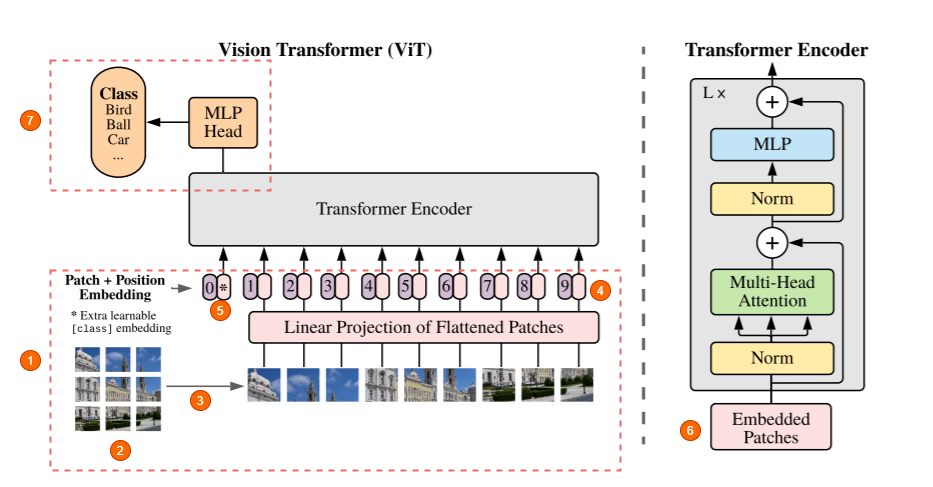

**(1)** They are only using the Encoder part of the transformer but the difference is in how they are feeding the images into the network. 

**(2)** They are breaking down the image into fixed size patches. So one of these patches can be of dimension 16x16 or 32x32 as proposed in the paper. More patches means more simpler it is to train these networks as the patches themselves get smaller. Hence we have that in the title - "An Image is worth 16x16 words". 

**(3)** The patches are then unrolled (flattened) and sent for further processing into the network.

**(4)** Unlike NNs here the model has no idea whatsoever about the position of the samples in the sequence, here each sample is a patch from the input image. So the image is fed **along with a positional embedding vector** and into the encoder. One thing to note here is the positional embeddings are also learnable so you don't actually feed hard-coded vectors w.r.t to their positions. 

**(5)** There is also a special token [CLS] at the start just like in BERT. [CLS] stands for classification. It is added at the beginning because the training tasks here is image classification. And because they need an input that can represent the meaning of the entire image, they introduce a new tag. So they add a tag that has no other purpose than being a image-level representation for classification.

**(6)** So each image patch is first unrolled (flattened) into a big vector and gets multiplied with an embedding matrix which is also learnable, creating embedded patches. And these embedded patches are combined with the positional embedding vector and that gets fed into the Transformer. 

> **Note: From here everything is just the same as a standard transformer**

**(7)** With the only difference being, instead of a decoder the output from the encoder is passed directly into a Feed Forward Neural Network to obtain the classification output. 

https://1.bp.blogspot.com/-_mnVfmzvJWc/X8gMzhZ7SkI/AAAAAAAAG24/8gW2AHEoqUQrBwOqjhYB37A7OOjNyKuNgCLcBGAsYHQ/s16000/image1.gif

# Part 2. Transformers in Action: Hugging Face. <a class="anchor" id="second-bullet"></a>

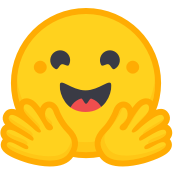

Hugging Face platform was launched in 2016. This platform offers thousands of pre-trained models to perform tasks such as text classification, extraction, question answering, and even image classification. With its low compute costs, it is considered a low barrier entry for educators and practitioners, and makes it possible for us to get our hands on such models.  

**Explore Huggingface Models Browser:**

https://huggingface.co/models

**Huggingface Course:**

https://huggingface.co/course/chapter1/1

First, let's download the latest version of transformers library from Huggingface:

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

## Example 1. Transformers applied to NLP problems

Every NLP task starts with a piece of text, like the following made-up customer feedback about a certain online order:

In [2]:
text = '''Dear Amazon, last week I ordered an Optimus Prime action figure
from your online store in Germany. Unfortunately, when I opened the package,
I discovered to my horror that I had been sent an action figure of Megatron
instead! As a lifelong enemy of the Decepticons, I hope you can understand my
dilemma. To resolve the issue, I demand an exchange of Megatron for the
Optimus Prime figure I ordered. Enclosed are copies of my records concerning
this purchase. I expect to hear from you soon. Sincerely, Bumblebee.'''

Depending on your application, the text you’re working with could be a legal contract, a product description, or something else entirely. In the case of customer feedback, you would probably like to know whether the feedback is positive or negative. This task is called sentiment analysis and is part of the broader topic of text classification. For now, let’s have a look at what it takes to extract the sentiment from our piece of text using Huggingface Transformers.

### Text classification

Huggingface Transformers has a layered API that allows you to interact with the library at various levels of abstraction. We’ll start with pipelines, which abstract away all the steps needed to convert raw text into a set of predictions from a fine-tuned model. Pipeline offers a simple API dedicated to several tasks, including Named Entity Recognition, Masked Language Modeling, Sentiment Analysis, Feature Extraction and Question Answering.

In Huggingface Transformers, we instantiate a pipeline by calling the pipeline() function and providing the name of the task we are interested in:

In [21]:
from transformers import pipeline

classifier = pipeline("text-classification")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


The first time you run this code you’ll see a few progress bars appear because the pipeline automatically downloads the model weights from the Hugging Face Hub. The second time you instantiate the pipeline, the library will notice that you’ve already downloaded the weights and will use the cached version instead. By default, the text-classification pipeline uses a model that’s designed for sentiment analysis, but it also supports multiclass and multilabel classification.

**Task: explore distilbert-base-uncased-finetuned-sst-2-english model cart in Hugging Face hub!**

Now that we have our pipeline, let’s generate some predictions! Each pipeline takes a string of text (or a list of strings) as input and returns a list of predictions. Each prediction is a Python dictionary, so we can use Pandas to display them nicely as a Data⁠Frame:

In [22]:
import pandas as pd

outputs = classifier(text)
pd.DataFrame(outputs)   

,label,score
0,NEGATIVE,0.901546


In this case the model is very confident that the text has a negative sentiment, which makes sense given that we’re dealing with a complaint from an angry customer! Note that for sentiment analysis tasks the pipeline only returns one of the POSITIVE or NEGATIVE labels, since the other can be inferred by computing 1-score.

Let’s now take a look at another common task, identifying named entities in text.

### Named Entity Recognition

Predicting the sentiment of customer feedback is a good first step, but you often want to know if the feedback was about a particular item or service. In NLP, real-world objects like products, places, and people are called named entities, and extracting them from text is called named entity recognition (NER). We can apply NER by loading the corresponding pipeline and feeding our customer review to it:

In [5]:
ner_tagger = pipeline("ner", aggregation_strategy="simple")
outputs = ner_tagger(text)
pd.DataFrame(outputs) 

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english)


,entity_group,score,word,start,end
0,ORG,0.879010,Amazon,5,11
1,MISC,0.990859,Optimus Prime,36,49
2,LOC,0.999755,Germany,90,97
3,MISC,0.556570,Mega,208,212
4,PER,0.590256,##tron,212,216
5,ORG,0.669692,Decept,253,259
6,MISC,0.498349,##icons,259,264
7,MISC,0.775362,Megatron,350,358
8,MISC,0.987854,Optimus Prime,367,380
9,PER,0.812096,Bumblebee,502,511


You can see that the pipeline detected all the entities and also assigned a category such as ORG (organization), LOC (location), or PER (person) to each of them. Here we used the aggregation_strategy argument to group the words according to the model’s predictions. For example, the entity “Optimus Prime” is composed of two words, but is assigned a single category: MISC (miscellaneous). The scores tell us how confident the model was about the entities it identified. We can see that it was least confident about “Decepticons” and the first occurrence of “Megatron”, both of which it failed to group as a single entity.

### Question Answering

In question answering, we provide the model with a passage of text called the context, along with a question whose answer we’d like to extract. The model then returns the span of text corresponding to the answer. Let’s see what we get when we ask a specific question about our customer feedback:

In [23]:
reader = pipeline("question-answering")
question = "What does the customer want?"
outputs = reader(question=question, context=text)
pd.DataFrame([outputs])

No model was supplied, defaulted to distilbert-base-cased-distilled-squad (https://huggingface.co/distilbert-base-cased-distilled-squad)


,score,start,end,answer
0,0.631292,335,358,an exchange of Megatron


We can see that along with the answer, the pipeline also returned start and end integers that correspond to the character indices where the answer span was found (just like with NER tagging).

With this approach you can read and extract relevant information quickly from a customer’s feedback. But what if you get a mountain of long-winded complaints and you don’t have the time to read them all? Let’s see if a summarization model can help!

### Summarization

The goal of text summarization is to take a long text as input and generate a short version with all the relevant facts. This is a much more complicated task than the previous ones since it requires the model to generate coherent text. In what should be a familiar pattern by now, we can instantiate a summarization pipeline as follows:

In [7]:
summarizer = pipeline('summarization')
outputs = summarizer(text, max_length=45, clean_up_tokenization_spaces=True)
print(outputs[0]['summary_text'])

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
Your min_length=56 must be inferior than your max_length=45.


 Bumblebee ordered an Optimus Prime action figure from your online store in Germany. Unfortunately, when I opened the package, I discovered to my horror that I had been sent an action figure of Megatron instead.


This summary isn’t too bad! Although parts of the original text have been copied, the model was able to capture the essence of the problem and correctly identify that “Bumblebee” (which appeared at the end) was the author of the complaint. In this example you can also see that we passed some keyword arguments like max_length and clean_up_tokenization_spaces to the pipeline; these allow us to tweak the outputs at runtime.

But what happens when you get feedback that is in a language you don’t understand? You could use Google Translate, or you can use your very own transformer to translate it for you!

### Translation

Like summarization, translation is a task where the output consists of generated text. Let’s use a translation pipeline to translate an English text to German:

In [8]:
translator = pipeline('translation_en_to_de',
                      model='Helsinki-NLP/opus-mt-en-de')
outputs = translator(text, clean_up_tokenization_spaces=True, min_length=100)
print(outputs[0]['translation_text'])

Sehr geehrter Amazon, letzte Woche habe ich eine Optimus Prime Action Figur aus Ihrem Online-Shop in Deutschland bestellt. Leider, als ich das Paket öffnete, entdeckte ich zu meinem Entsetzen, dass ich stattdessen eine Action Figur von Megatron geschickt worden war! Als lebenslanger Feind der Decepticons, Ich hoffe, Sie können mein Dilemma verstehen. Um das Problem zu lösen, Ich fordere einen Austausch von Megatron für die Optimus Prime Figur habe ich bestellt. Anbei sind Kopien meiner Aufzeichnungen über diesen Kauf. Ich erwarte, bald von Ihnen zu hören. Aufrichtig, Bumblebee.


## Example 2. Transformers applied to Computer Vision Problems

### Image Classification

In this example, we will be using *google/vit-base-patch16-224* pre-trained model from Huggingface. To see model card, please refer to the link: 
https://huggingface.co/google/vit-base-patch16-224


#### 1. Load the model from the hub, and move it to GPU.

In [9]:
from transformers import ViTForImageClassification
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.eval()
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

#### 2. Load in an image and let the model perform predictions.

I am using some image from the internet. Similarly, you could use some picture from your local machine:

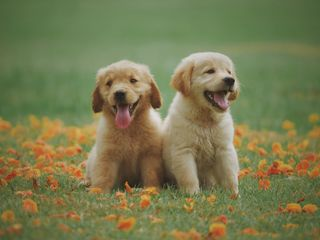

In [24]:
from PIL import Image
import requests

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'

url = 'https://i0.wp.com/shinesolutions.com/wp-content/uploads/2020/03/test-resize.jpg?fit=320%2C240&ssl=1'
im = Image.open(requests.get(url, stream=True).raw)
im

In [16]:
# !dir

Let's first apply the regular image preprocessing. This model accepts an input resolution of 224x224. We use `ViTFeatureExtractor`, which takes care of resizing + normalization.

In [25]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-large-patch16-224')
encoding = feature_extractor(images=im, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values'])

In [26]:
encoding['pixel_values'].shape

torch.Size([1, 3, 224, 224])

## Forward pass

Let's send the image through the ViT model, which consists of a BERT-like encoder and a linear classification head on top of the last hidden state of the [CLS] token.



In [ ]:
pixel_values = encoding['pixel_values'].to(device)

outputs = model(pixel_values)
logits = outputs.logits
logits.shape

torch.Size([1, 1000])

In [ ]:
prediction = logits.argmax(-1)
print("Predicted class:", model.config.id2label[prediction.item()])

Predicted class: golden retriever
